In [1]:
using QuantumClifford
using QuantumClifford.Experimental.NoisyCircuits
using Plots
using ProgressMeter

The perturbative expansion code supports symbolic calculation. Simply use one of the many symbolic packages in Julia and set the various parameters of interest to symbolic values instead of numeric ones. Here we show an example of a typical purification circuit that uses the `SymPy` computer algebra system.

## If you want to use AbstractAlgebra

In [2]:
using AbstractAlgebra
R, (e,) = PolynomialRing(RealField, ["e"])
unity = R(1);

In [3]:
good_bell_state = S"XX
                    ZZ"
canonicalize_rref!(good_bell_state)
initial_state = good_bell_state⊗good_bell_state

g1 = SparseGate(CNOT, [1,3]) # CNOT between qubit 1 and qubit 3 (both with Alice)
g2 = SparseGate(CNOT, [2,4]) # CNOT between qubit 2 and qubit 4 (both with Bob)
m = BellMeasurement([X,X],[3,4]) # Bell measurement on qubit 3 and 4
v = VerifyOp(good_bell_state,[1,2]) # Verify that qubit 1 and 2 indeed form a good Bell pair
epsilon = e # The error rate
n = NoiseOpAll(UnbiasedUncorrelatedNoise(epsilon))

# This circuit performs a depolarization at rate `epsilon` to all qubits,
# then bilater CNOT operations
# then a Bell measurement
# followed by checking whether the final result indeed corresponds to the correct Bell pair.
circuit = [n,g1,g2,m,v]

pe_symbolic = petrajectories(initial_state, circuit, branch_weight=unity) # perturbative expansion

Dict{Symbol,AbstractAlgebra.Generic.MPoly{BigFloat}} with 3 entries:
  :undetected_failure => -162.0*e^4 + 162.0*e^3 + -54.0*e^2 + 6.0*e
  :detected_failure   => -108.0*e^4 + 108.0*e^3 + -36.0*e^2 + 4.0*e
  :true_success       => 27.0*e^4 + -54.0*e^3 + 36.0*e^2 + -10.0*e + 1.0

## If you want to use SymPy

In [4]:
using SymPy
e = Sym("e")
unity = Sym(1);

In [5]:
good_bell_state = S"XX
                    ZZ"
canonicalize_rref!(good_bell_state)
initial_state = good_bell_state⊗good_bell_state

g1 = SparseGate(CNOT, [1,3]) # CNOT between qubit 1 and qubit 3 (both with Alice)
g2 = SparseGate(CNOT, [2,4]) # CNOT between qubit 2 and qubit 4 (both with Bob)
m = BellMeasurement([X,X],[3,4]) # Bell measurement on qubit 3 and 4
v = VerifyOp(good_bell_state,[1,2]) # Verify that qubit 1 and 2 indeed form a good Bell pair
epsilon = e # The error rate
n = NoiseOpAll(UnbiasedUncorrelatedNoise(epsilon))

# This circuit performs a depolarization at rate `epsilon` to all qubits,
# then bilater CNOT operations
# then a Bell measurement
# followed by checking whether the final result indeed corresponds to the correct Bell pair.
circuit = [n,g1,g2,m,v]

pe_symbolic = petrajectories(initial_state, circuit, branch_weight=unity) # perturbative expansion

Dict{Symbol,Sym} with 3 entries:
  :undetected_failure => 6.0*e*(1 - 3*e)^3
  :detected_failure   => 4.0*e*(1 - 3*e)^3
  :true_success       => 2.0*e*(1 - 3*e)^3 + 1.0*(1 - 3*e)^4

## Comparison to numeric result

In [6]:
true_success_symbolic = pe_symbolic[:true_success]

               3                4
2.0⋅e⋅(1 - 3⋅e)  + 1.0⋅(1 - 3⋅e) 

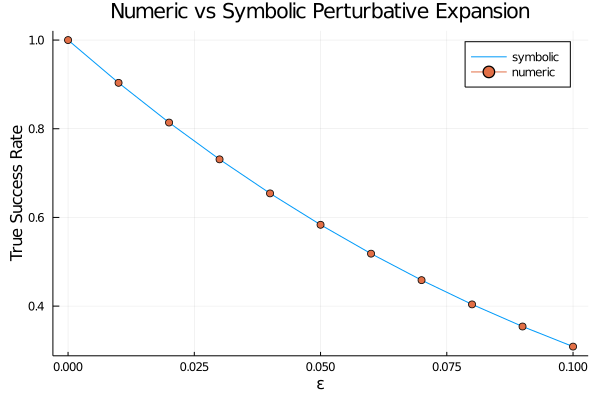

In [7]:
es_num = 0:0.01:0.1
symbolic_evaluations = [Float64(true_success_symbolic.subs(e,e_num)) for e_num in es_num]

numeric_evaluations = []
for epsilon in es_num
    n = NoiseOpAll(UnbiasedUncorrelatedNoise(epsilon))
    circuit = [n,g1,g2,m,v]
    pe_symbolic = petrajectories(initial_state, circuit)
    push!(numeric_evaluations, pe_symbolic[:true_success])
end

plot(es_num, symbolic_evaluations, label="symbolic")
plot!(es_num, numeric_evaluations, line=false, marker=true, label="numeric")
plot!(xlabel="ε", ylabel="True Success Rate", title="Numeric vs Symbolic Perturbative Expansion")